In [1]:
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import datetime, timezone
import math
import os
import re
import gc

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

from xgboost import XGBRegressor, plot_importance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
#from keras_tuner.oracles import BayesianOptimization

import seaborn as sns
import pickle

# Helper functions

In [ ]:
# Borrowing this helper function from HW 1 to help with saving images for later

# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Docstring for save_fig
    
    :param fig_id: Description
    :param tight_layout: Description
    :param fig_extension: Description
    :param resolution: Description
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_model(model_name, model, nn=False):
    print("Saving model", model_name)
    if nn:
        path = os.path.join(MODELS_PATH, model_name + ".h5")
        model.save(path)
        return
    path = os.path.join(MODELS_PATH, model_name + ".pkl")
    with open(path,'wb') as f:
        pickle.dump(model,f)

In [3]:
def reset_tf_state() -> None:

    tf.keras.backend.clear_session()
    try:
        tf.compat.v1.reset_default_graph()
    except Exception:
        pass
    gc.collect()


In [59]:
def log_hyperparams(model_name, target_name, sampling_freq, hparams, filename="nonlin_hparams.csv"):
    """
    Append model name, target, sampling frequency, and hyperparameter
    name/value pairs to a CSV with NO headers.

    Format per row:
    model_name, target_name, sampling_freq, hp1_name, hp1_value, hp2_name, hp2_value, ...
    """

    # Start with the fixed identifiers
    row = [model_name, target_name, sampling_freq]

    # Append hyperparameter name/value pairs
    for name, value in hparams.items():
        row.append(name)
        row.append(value)

    # Wrap into DataFrame and append with no header
    df = pd.DataFrame([row])
    df.to_csv(filename, mode="a", header=False, index=False)

    print(f' - Hyperparameters appended to "{filename}" (name/value pairs, no headers)')


def print_metrics(model_str, targ, Y_tr, Y_va, yhat_tr, yhat_va, step_size, save=True):
    """
    Docstring for print_metrics
    
    :param model_str:  Description
    :param targ:       Description
    :param Y_tr:       Description
    :param Y_va:       Description
    :param yhat_tr:    Description
    :param yhat_va:    Description
    :param save:       Description
    """

    rmse_tr = mean_squared_error(Y_tr, yhat_tr) ** 0.5
    rmse_va = mean_squared_error(Y_va, yhat_va) ** 0.5
    r2_tr   = r2_score(Y_tr, yhat_tr)
    r2_va   = r2_score(Y_va, yhat_va)
    print(f"RESULTS FOR {targ} ({model_str}, {step_size})")
    print(f"Train | RMSE: {rmse_tr:.4f} | R^2: {r2_tr:.4f}")
    print(f"Val   | RMSE: {rmse_va:.4f} | R^2: {r2_va:.4f}\n")

    if save:

        metric_file = "data/nonlin_res.csv"
        
        cols = ["sampling frequency", "model_name", "target_name", "training_rmse", "training_r2", "validation_rmse", "validation_r2"]
        
        res = pd.DataFrame([[step_size, model_str, targ, rmse_tr, r2_tr, rmse_va, r2_va]], columns=cols)
        write_header = not os.path.exists(metric_file)
        res.to_csv(metric_file, mode="a", header=write_header, index=False)
        print(f" - Performance metrics written to file: \"{write_header}\"")


def print_tscv_metrics(model_name, target_name, fold_r2, fold_rmse, step_size, save=True):
    """
    Print time series CV metrics and optionally append them to a CSV file.

    CSV format (columns):
        step_size, model_name, target_name, mean_rmse, mean_r2,
        val_rmse_1, val_r2_1, val_rmse_2, val_r2_2, ...

    :param model_name:  Name of the model (string)
    :param target_name: Target variable name (string)
    :param fold_r2:     List of validation R^2 scores (one per fold)
    :param fold_rmse:   List of validation RMSE scores (one per fold)
    :param step_size:   Sampling step size in seconds (int)
    :param save:        If True, append results to CSV
    :param filename:    CSV file name (default: "tscv_results.csv")
    """

    filename = "data/tscv_results.csv"

    if len(fold_r2) != len(fold_rmse):
        raise ValueError("fold_r2 and fold_rmse must have the same length.")

    n_folds = len(fold_r2)

    # Compute means
    mean_r2 = float(np.nanmean(fold_r2))   if n_folds > 0 else np.nan
    mean_rmse = float(np.nanmean(fold_rmse)) if n_folds > 0 else np.nan

    # ---- Print to screen ----
    print(f"\n=== Time Series CV Metrics ===")
    print(f"Model: {model_name}")
    print(f"Target: {target_name}")
    print(f"Step size: {step_size} seconds")
    print(f"Number of folds: {n_folds}\n")

    for i, (rmse, r2) in enumerate(zip(fold_rmse, fold_r2), start=1):
        print(f"Fold {i:2d} | Val RMSE: {rmse:.5f} | Val R^2: {r2:.4f}")

    print("\n--- Summary ---")
    print(f"Mean Val RMSE: {mean_rmse:.5f}")
    print(f"Mean Val R^2:  {mean_r2:.4f}\n")

    # ---- Optionally save to CSV ----
    if save:
        # Base columns
        cols = [
            "step_size",
            "model_name",
            "target_name",
            "mean_rmse",
            "mean_r2",
        ]

        # Per-fold columns
        for k in range(1, n_folds + 1):
            cols.append(f"val_rmse_{k}")
            cols.append(f"val_r2_{k}")

        # Build row values
        row = [step_size, model_name, target_name, mean_rmse, mean_r2]
        for rmse, r2 in zip(fold_rmse, fold_r2):
            row.append(rmse)
            row.append(r2)

        df_row = pd.DataFrame([row], columns=cols)

        # Decide whether to write header
        write_header = (not os.path.exists(filename)) or os.path.getsize(filename) == 0

        df_row.to_csv(filename, mode="a", header=write_header, index=False)

        print(f' - Time series CV metrics appended to "{filename}"')


def save_preds(model_str, targ, X_tr, X_va, yhat_tr, yhat_va, step_size, save_dir="data/plotdata"):
    """
    Docstring for save_preds
    
    :param model_str: Description
    :param targ: Description
    :param X_tr: Description
    :param X_va: Description
    :param yhat_tr: Description
    :param yhat_va: Description
    :param save_dir: Description
    """
    
    yhat_tr_s = pd.Series(yhat_tr, index=X_tr.index, name="Predicted (Train)")
    yhat_va_s = pd.Series(yhat_va, index=X_va.index, name="Predicted (Val)")
    exp_data = pd.concat([yhat_tr_s, yhat_va_s], axis=1)
    pred_data_str = f"{save_dir}/{step_size}_{targ}_{model_str.replace(" ", "_").lower()}_preds.csv"
    exp_data.to_csv(f"{pred_data_str}")

    print(f" - Model pred data written to file: \"{pred_data_str}\"\n     SAMPLING FREQ: {step_size}\n     MODEL: {model_str}\n     TARGET: {targ}\n")


def plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr, yhat_va, model_name, TARGET='RSTDEV_Fidelity_300_SAVGOL', tuned=True, step_size=30, save=True):
    """
    Docstring for plot_res_train_val
    
    :param df:          Description
    :param X_tr:        Description
    :param X_va:        Description
    :param Y_tr:        Description
    :param Y_va:        Description
    :param yhat_tr:     Description
    :param yhat_va:     Description
    :param model_name:  Description
    :param TARGET:      Description
    :param tuned:       Description
    :param step_size:   Number of seconds per observation (30 = 30 second, 60 = 1 minute, 120 = 2 minute)
    :param save:        Whether to save plot in dir specified in save_fig function (default True)
    """

    tuned_str = "Tuned" if tuned else "Baseline"
    sf_str = "30 Sec" if step_size == 30 else f"{step_size//60} Min"
    file_str = f"{TARGET}_{model_name.replace(" ", "_").lower()}_{tuned_str}_preds"

    init_time = 1696015500
    #end_time  = 1696262370

    sep_29_sunset = 1696028100
    sep_30_sunset = 1696114380
    oct_01_sunset = 1696200660

    sep_30_sunrise = 1696071780
    oct_01_sunrise = 1696158240
    oct_02_sunrise = 1696244700

    sep_30_mid_day = 1696089600
    oct_01_mid_day = 1696176000


    # Convert from millis to seconds
    if df["current_time"].max() > 2e10:
        df["current_time"] = (df["current_time"] // 1000).astype("int64")

    # ----- Build the combined y and indices as before -----
    yhat_tr_s = pd.Series(yhat_tr, index=X_tr.index, name="Predicted (Train)")
    yhat_va_s = pd.Series(yhat_va, index=X_va.index, name="Predicted (Val)")

    # Moved to separate function
    #exp_data = pd.concat([yhat_tr_s, yhat_va_s], axis=1)
    #exp_data.to_csv(f"{file_str}.csv")

    y_all = pd.concat([Y_tr, Y_va])
    sep_x = X_va.index[0]   # boundary between train and val (index units)

    # ----- Convert key times to index positions (same as your other plot) -----
    # Midday tick positions
    tick_positions = [
        (sep_30_mid_day - init_time) // step_size,
        (oct_01_mid_day - init_time) // step_size,
    ]

    tick_labels = [
        datetime.fromtimestamp(ts, tz=timezone.utc).strftime("%d %b")
        for ts in [sep_30_mid_day, oct_01_mid_day]
    ]

    # Night-time index ranges
    sep_29_set_idx = (sep_29_sunset  - init_time) // step_size
    sep_30_rise_idx = (sep_30_sunrise - init_time) // step_size
    sep_30_set_idx = (sep_30_sunset  - init_time) // step_size
    oct_01_rise_idx = (oct_01_sunrise - init_time) // step_size
    oct_01_set_idx = (oct_01_sunset  - init_time) // step_size
    oct_02_rise_idx = (oct_02_sunrise - init_time) // step_size

    # Optionally add start/end labels like in your cloud-cover plot
    tick_positions.insert(0, 0)
    #tick_positions.append(len(y_all) - 1)

    tick_labels.insert(0, "29 Sep")
    #tick_labels.append("02 Oct")

    # ----- Plot -----
    fig, ax = plt.subplots(figsize=(12, 4.8))

    ax.plot(y_all.index,      y_all,      label="Actual",            linewidth=1.8)
    ax.plot(yhat_tr_s.index,  yhat_tr_s,  label="Predicted (Train)", linewidth=1.8, alpha=0.9)
    ax.plot(yhat_va_s.index,  yhat_va_s,  label="Predicted (Val)",   linewidth=1.8, alpha=0.9)

    # Train/val separator
    ax.axvline(sep_x, linestyle="--", linewidth=1.2)

    # Nighttime shading (same style as your cloud-cover figure)
    ax.axvspan(sep_29_set_idx, sep_30_rise_idx, alpha=0.3, color="gray")
    ax.axvspan(sep_30_set_idx, oct_01_rise_idx, alpha=0.3, color="gray")
    ax.axvspan(oct_01_set_idx, oct_02_rise_idx, alpha=0.3, color="gray")

    # X ticks / labels = day + month
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel("Date")
    ax.set_ylabel(TARGET)
    ax.set_title(f"{model_name} ({tuned_str}, {sf_str} SF) Actual vs Predicted (Train + Validation)")
    ax.legend()
    plt.tight_layout()
    save_fig(f"{file_str}")
    plt.show()

    df = df.drop('current_time', axis=1)

In [11]:
@dataclass(frozen=True)
class SamplingConfig:
    label: str
    seconds: int

SEC30 = SamplingConfig("30SEC", 30)
MIN1  = SamplingConfig("1MIN", 60)
MIN2  = SamplingConfig("2MIN", 120)

# Data Initialization

### Set variables here:

In [57]:
# SET TARGET HERE:
TARGET = "RSTDEV_Fidelity_300_SAVGOL"
# SET SAMP FREQ HERE:
SAMPLING = SEC30

# For TSCV:
SECONDS_PER_DAY = 86400
DAY = SECONDS_PER_DAY // SAMPLING.seconds
HALF = DAY // 2
LOOKBACK_REFACTOR_CONSTANT = 3600
LOOKBACK = LOOKBACK_REFACTOR_CONSTANT // SAMPLING.seconds
GRU_LOOKBACK = 240
HORIZON = 1
GAP = 1

print(f"TARGET: {TARGET};   SF: {SAMPLING.label};   SAMPLES/DAY: {DAY};   SAMPLES/HALFDAY: {HALF};   LOOKBACK: {LOOKBACK}\n")

df = pd.read_csv(f"data/new/processed/{SAMPLING.label}.csv")

df.info()

TARGET: RSTDEV_Fidelity_300_SAVGOL;   SF: 30SEC;   SAMPLES/DAY: 2880;   SAMPLES/HALFDAY: 1440;   LOOKBACK: 120

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231 entries, 0 to 8230
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   current_time                 8231 non-null   int64  
 1   time_of_day_ms               8231 non-null   int64  
 2   tod_sin                      8231 non-null   float64
 3   tod_cos                      8231 non-null   float64
 4   cloud_cover_x                8231 non-null   float64
 5   humidity_x                   8231 non-null   float64
 6   pressure_x                   8231 non-null   float64
 7   temperature_x                8231 non-null   float64
 8   vis_x                        8231 non-null   float64
 9   wind_dir_x                   8231 non-null   float64
 10  wind_gust_x                  8231 non-null   float64
 11  wind_speed_x          

In [58]:
'''
X_all = df.iloc[:, 2:28].copy()
Y = df[TARGET].copy()

n = len(df)
n_tr = int(n * 0.70)
n_va = int(n * 0.15)
n_te = n - n_tr - n_va

X_tr, Y_tr = X_all.iloc[:n_tr],             Y.iloc[:n_tr]
X_va, Y_va = X_all.iloc[n_tr:n_tr+n_va],    Y.iloc[n_tr:n_tr+n_va]
X_te, Y_te = X_all.iloc[n_tr+n_va:],        Y.iloc[n_tr+n_va:]

print(f"Shapes -> X_tr:{X_tr.shape}, X_va:{X_va.shape}, X_te:{X_te.shape}")
'''

def data_reset(df, TARGET):
    X_all = df.iloc[:, 2:28].copy()
    Y = df[TARGET].copy()
    
    n = len(df)
    n_tr = int(n * 0.70)
    n_va = int(n * 0.15)
    n_te = n - n_tr - n_va
    
    X_tr, Y_tr = X_all.iloc[:n_tr],             Y.iloc[:n_tr]
    X_va, Y_va = X_all.iloc[n_tr:n_tr+n_va],    Y.iloc[n_tr:n_tr+n_va]
    X_te, Y_te = X_all.iloc[n_tr+n_va:],        Y.iloc[n_tr+n_va:]
    
    print(f"Shapes -> X_tr:{X_tr.shape}, X_va:{X_va.shape}, X_te:{X_te.shape}")

    return X_all, Y, n, n_tr, n_va, n_te, X_tr, Y_tr, X_va, Y_va, X_te, Y_te

X_all, Y, n, n_tr, n_va, n_te, X_tr, Y_tr, X_va, Y_va, X_te, Y_te = data_reset(df, TARGET)

Shapes -> X_tr:(5761, 26), X_va:(1234, 26), X_te:(1236, 26)


## XGBoost Regression

### Baseline

=== Baseline performance ===
RESULTS FOR RSTDEV_Fidelity_300_SAVGOL (xgb_baseline, 30SEC)
Train | RMSE: 0.0004 | R^2: 0.9997
Val   | RMSE: 0.0098 | R^2: 0.7863

 - Performance metrics written to file: "True"
 - Model pred data written to file: "data/plotdata/30SEC_RSTDEV_Fidelity_300_SAVGOL_xgb_baseline_preds.csv"
     SAMPLING FREQ: 30SEC
     MODEL: xgb_baseline
     TARGET: RSTDEV_Fidelity_300_SAVGOL

Saving figure RSTDEV_Fidelity_300_SAVGOL_xgboost_Baseline_preds


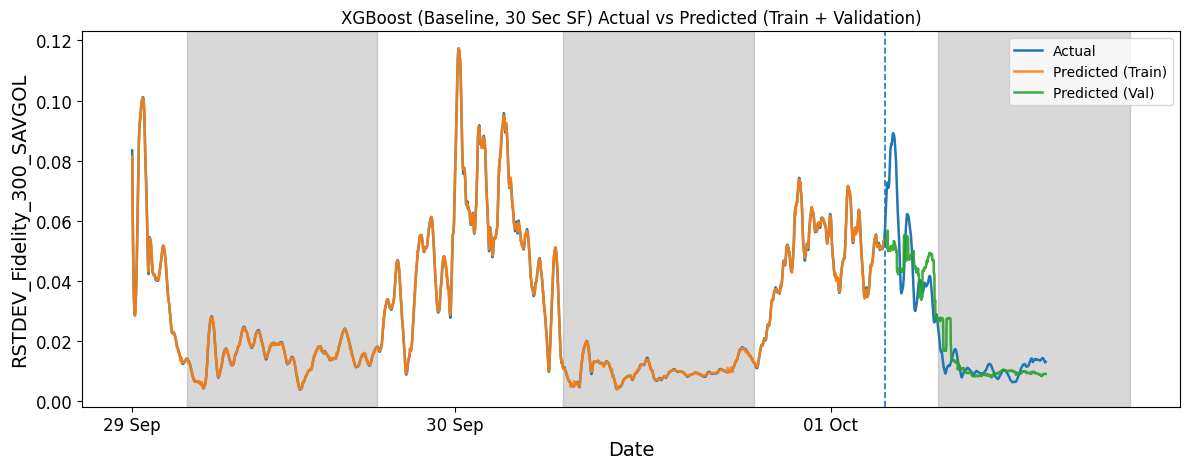

In [ ]:
model_str = "XGBoost"

model_name = "xgb_baseline"
tuned_ver = False

baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
)

baseline.fit(
    X_tr, Y_tr,
    eval_set=[(X_va, Y_va)],
    verbose=False
)
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", baseline)

print("=== Baseline performance ===")
yhat_tr_b = baseline.predict(X_tr)
yhat_va_b = baseline.predict(X_va)


print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)


### Tuned

Best params: {'n_estimators': 400, 'learning_rate': 0.3156765118876256, 'max_depth': 12, 'subsample': 0.7887166029575389, 'colsample_bytree': 0.7286336411477805, 'reg_alpha': 3.992118884982587e-06, 'reg_lambda': 0.01671612706846758, 'min_child_weight': 7, 'gamma': 0.05593376543438444}
Train | RMSE: 0.00971 | R^2: 0.8254
Val   | RMSE: 0.00895 | R^2: 0.8225
RESULTS FOR RSTDEV_Fidelity_300_SAVGOL (xgb_tuned, 30SEC)
Train | RMSE: 0.0097 | R^2: 0.8254
Val   | RMSE: 0.0089 | R^2: 0.8225

 - Performance metrics written to file: "False"
 - Hyperparameters appended to "nonlin_hparams.csv" (name/value pairs, no headers)
 - Model pred data written to file: "data/plotdata/30SEC_RSTDEV_Fidelity_300_SAVGOL_xgb_tuned_preds.csv"
     SAMPLING FREQ: 30SEC
     MODEL: xgb_tuned
     TARGET: RSTDEV_Fidelity_300_SAVGOL

Saving figure RSTDEV_Fidelity_300_SAVGOL_xgboost_Tuned_preds


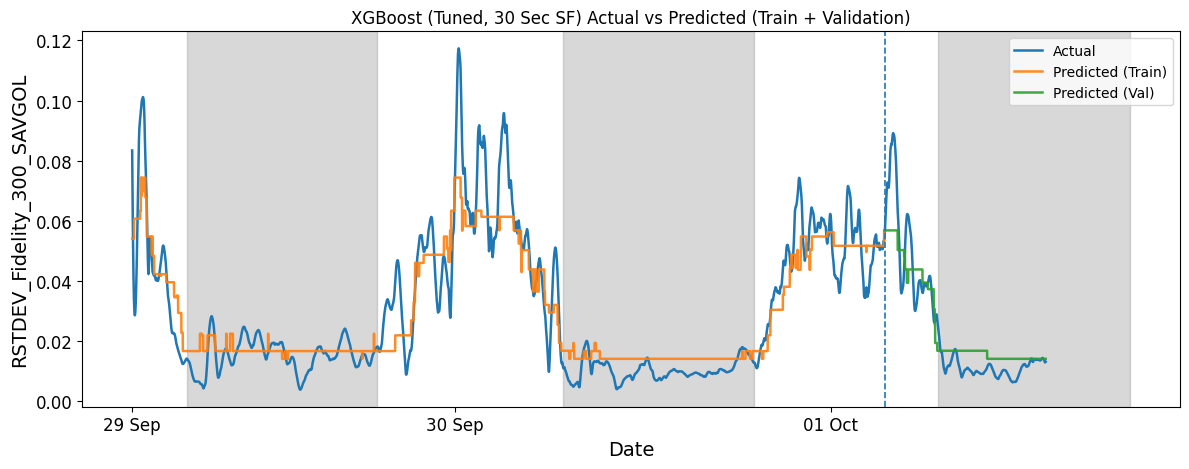

In [ ]:
model_name = "xgb_tuned"
tuned_ver = True

rng = np.random.default_rng(42)
N_TRIALS = 500  # i found that 300-500 is good for a search of the params I looked through below

best_rmse = math.inf
best_r2 = 0.0
best_model, best_params = None, None

for _ in range(N_TRIALS):
    params = {
        "n_estimators": int(rng.choice([200, 400, 600, 800, 1000, 1200])),
        "learning_rate": float(10 ** rng.uniform(-2.0, -0.3)),
        "max_depth": int(rng.integers(3, 13)),
        "subsample": float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "reg_alpha": float(10 ** rng.uniform(-6, 1)),
        "reg_lambda": float(10 ** rng.uniform(-3, 2)),
        "min_child_weight": int(rng.integers(1, 11)),
        "gamma": float(rng.uniform(0.0, 5.0)),
    }

    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        **params
    )

    model.fit(X_tr, Y_tr)

    yhat_va = model.predict(X_va)
    rmse_va = mean_squared_error(Y_va, yhat_va) ** 0.5
    r2_va = r2_score(Y_va, yhat_va)

    if r2_va > best_r2:
        best_r2 = r2_va
        best_model = model
        best_params = params

save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", best_model)
print(f"Best params: {best_params}\n")

yhat_tr = best_model.predict(X_tr)
yhat_va = best_model.predict(X_va)



print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best_params
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)



#### Time-series cross-validation (TSCV), also called walk-forward or forward-chaining cross validation:

In [ ]:

# I keep running this without running the previous block, so I put this in to put defaults for quick testing
try:
    best_params
    tuned_ver = True
    model_name = "xgb_tuned"
except NameError:
    best_params = {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.0,
        'reg_lambda': 1.0,
        'min_child_weight': 1,
        'gamma': 0.0
    }
    tuner_ver = False
    model_name = "xgb_baseline"

# i kept this in to enforce objective and method since I was having issues without it
fixed = {"objective": "reg:squarederror", "random_state": 42, "n_jobs": -1, "tree_method": "hist"}
params = {**best_params, **{k:v for k,v in fixed.items() if k not in best_params}}

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    tr_idx = np.arange(0, train_end)
    va_idx = np.arange(val_start, val_end)

    model = XGBRegressor(**params)
    model.fit(X_all.iloc[tr_idx], Y.iloc[tr_idx])

    y_va   = Y.iloc[va_idx]
    y_pred = model.predict(X_all.iloc[va_idx])

    rmse = mean_squared_error(y_va, y_pred) ** 0.5
    r2   = r2_score(y_va, y_pred)
    if r2 < 0:
        r2 = 0.0


    print(f"Fold {fold} | train[0:{train_end}) gap[{train_end}:{val_start}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    # advance by half-day
    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2881 : 4321)
Fold 1 | train[0:2880) gap[2880:2881) val[2881:4321) | R^2: 0.0000 | RMSE: 0.02081
Val index: (4321 : 5761)
Fold 2 | train[0:4320) gap[4320:4321) val[4321:5761) | R^2: 0.5489 | RMSE: 0.01378
Val index: (5761 : 7201)
Fold 3 | train[0:5760) gap[5760:5761) val[5761:7201) | R^2: 0.7808 | RMSE: 0.00934
Val index: (7201 : 8641)

=== Forward-chaining summary ===
Mean R^2:   0.4433
Mean RMSE:  0.01464


### SVR Regression

##### Baseline

In [ ]:
model_str = "Support Vector Regression"

model_name = "svr_baseline"
tuned_ver = False


svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale")),
])

model = TransformedTargetRegressor(
    regressor=svr_pipe,
    transformer=StandardScaler()
)

model.fit(X_tr, y_tr)
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", model)

yhat_tr_b = model.predict(X_tr)
yhat_va_b = model.predict(X_va)

print("\n=== SVR Baseline (RBF) ===")

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)


=== SVR Baseline (RBF) ===
Train | RMSE: 0.00264 | R^2: 0.9871
Val   | RMSE: 0.01549 | R^2: 0.4683


##### Tuned

In [ ]:
model_name = "svr_tuned"
tuned_ver = True

rng = np.random.default_rng(123)

def make_model(C, eps, gamma):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf", C=C, epsilon=eps, gamma=gamma)),
    ])
    return TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

best = {"r2": -np.inf, "rmse": np.inf, "C": None, "eps": None, "gamma": None, "model": None}

N_TRIALS_COARSE = 60
for _ in range(N_TRIALS_COARSE):
    C   = 10 ** rng.uniform(-2, 3)
    eps = 10 ** rng.uniform(-3, -0.3)
    gpick = rng.uniform()
    if gpick < 0.34:
        gamma = "scale"
    elif gpick < 0.68:
        gamma = "auto"
    else:
        gamma = 10 ** rng.uniform(-4, 0)

    mdl = make_model(C, eps, gamma)
    mdl.fit(X_tr, y_tr)
    yhat_va = mdl.predict(X_va)
    r2_va   = r2_score(y_va, yhat_va)
    if r2_va > best["r2"]:
        best.update({
            "r2": r2_va,
            "rmse": float(mean_squared_error(y_va, yhat_va) ** 0.5),
            "C": C, "eps": eps, "gamma": gamma, "model": mdl
        })

print("\n=== After coarse search ===")
print(f"Best so far -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f} | "
      f"C: {best['C']:.5g} | eps: {best['eps']:.5g} | gamma: {best['gamma']}")

N_TRIALS_REFINE = 40
best_C, best_eps, best_gamma = best["C"], best["eps"], best["gamma"]

for _ in range(N_TRIALS_REFINE):
    C   = best_C  * (10 ** rng.uniform(-0.5, 0.5))
    eps = best_eps* (10 ** rng.uniform(-0.5, 0.5))
    if isinstance(best_gamma, (int, float)):
        gamma = best_gamma * (10 ** rng.uniform(-0.5, 0.5))
    else:
        gamma = best_gamma if rng.uniform() < 0.5 else ("scale" if best_gamma=="auto" else "auto")

    mdl = make_model(C, eps, gamma)
    mdl.fit(X_tr, y_tr)
    yhat_va = mdl.predict(X_va)
    r2_va   = r2_score(y_va, yhat_va)
    if r2_va > best["r2"]:
        best.update({
            "r2": r2_va,
            "rmse": float(mean_squared_error(y_va, yhat_va) ** 0.5),
            "C": C, "eps": eps, "gamma": gamma, "model": mdl
        })

print("\n=== Tuned SVR (best on validation) ===")
print(f"Best params -> C: {best['C']:.6g} | epsilon: {best['eps']:.6g} | gamma: {best['gamma']}")
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

best_model = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", best_model)

yhat_tr = best_model.predict(X_tr)
yhat_va = best_model.predict(X_va)

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best.pop("model", None)
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:


svr_params = {"C": best["C"], "epsilon": best["eps"], "gamma": best["gamma"], "kernel": "rbf"}

# set this back to 0 here. maybe standardize them later?
GAP  = 0

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    tr_idx = np.arange(0, train_end)
    va_idx = np.arange(val_start, val_end)

    svr_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(**svr_params)),
    ])
    model = TransformedTargetRegressor(regressor=svr_pipe, transformer=StandardScaler())

    model.fit(X_all.iloc[tr_idx], Y.iloc[tr_idx])

    y_va   = Y.iloc[va_idx]
    y_pred = model.predict(X_all.iloc[va_idx])

    rmse = mean_squared_error(y_va, y_pred) ** 0.5
    r2   = r2_score(y_va, y_pred)
    if r2 < 0:
        r2 = 0.0

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1

print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)


Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.02351
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.2791 | RMSE: 0.01742
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.7784 | RMSE: 0.00940
Val index: (7200 : 8640)

=== Forward-chaining summary (SVR) ===
Mean R^2:   0.3525
Mean RMSE:  0.01678


### Random forest regression

##### Baseline

Shapes -> X_tr:(5761, 26), X_va:(1234, 26), X_te:(1236, 26)

=== RandomForest Baseline ===
Train | RMSE: 0.00031 | R^2: 0.9998
Val   | RMSE: 0.00959 | R^2: 0.7963

=== Tuned RandomForest (selected by Val R^2) ===
Best params -> n_estimators: 200, max_depth: 3
Val metrics  -> R^2: 0.8549 | RMSE: 0.00809

=== Tuned RandomForest — Full report ===
Train | RMSE: 0.00905 | R^2: 0.8484
Val   | RMSE: 0.00809 | R^2: 0.8549


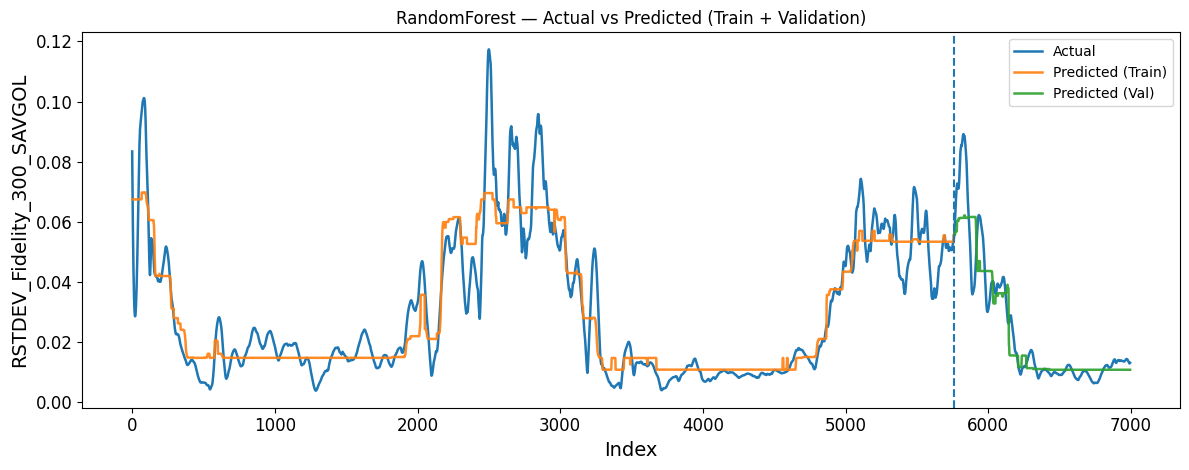

In [ ]:

model_str = "Random Forest"

model_name = "rf_baseline"
tuned_ver = False

rf_base = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)
rf_base.fit(X_tr, y_tr)
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", rf_base)

yhat_tr_b = rf_base.predict(X_tr)
yhat_va_b = rf_base.predict(X_va)

print("\n=== RandomForest Baseline ===")

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

In [ ]:
model_name = "rf_tuned"
tuned_ver = True

est_grid   = [200, 400, 600, 800, 1000]
depth_grid = [None, 3, 4, 6, 8, 10, 12, 16, 20]

best = {"r2": -np.inf, "rmse": np.inf, "n_estimators": None, "max_depth": None, "model": None}

for n_est in est_grid:
    for depth in depth_grid:
        rf = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=depth,
            random_state=42,
            n_jobs=-1,
            bootstrap=True
        )
        rf.fit(X_tr, y_tr)
        yhat_va = rf.predict(X_va)
        r2_va   = r2_score(y_va, yhat_va)
        if r2_va > best["r2"]:
            best.update({
                "r2": r2_va,
                "rmse": float(mean_squared_error(y_va, yhat_va) ** 0.5),
                "n_estimators": n_est,
                "max_depth": depth,
                "model": rf
            })

print("\n=== Tuned RandomForest (selected by Val R^2) ===")
print(f"Best params -> n_estimators: {best['n_estimators']}, max_depth: {best['max_depth']}")
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

rf_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", rf_best)

yhat_tr = rf_best.predict(X_tr)
yhat_va = rf_best.predict(X_va)

print("\n=== Tuned RandomForest — Full report ===")

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best.pop("model", None)
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:
rf_params = {"n_estimators": rf_best.n_estimators, "max_depth": rf_best.max_depth}

GAP  = 0
H    = 1

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    tr_idx = np.arange(0, train_end)
    va_idx = np.arange(val_start, val_end)

    model = RandomForestRegressor(
        n_estimators=rf_params["n_estimators"],
        max_depth=rf_params["max_depth"],
        random_state=42,
        n_jobs=-1,
        bootstrap=True
    )
    model.fit(X_all.iloc[tr_idx], Y.iloc[tr_idx])

    y_va   = Y.iloc[va_idx]
    y_pred = model.predict(X_all.iloc[va_idx])

    rmse  = mean_squared_error(y_va, y_pred) ** 0.5
    r2    = r2_score(y_va, y_pred)
    if r2 < 0:
        r2 = 0.0


    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.02592
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.4115 | RMSE: 0.01574
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.8548 | RMSE: 0.00761
Val index: (7200 : 8640)

=== Forward-chaining summary (RandomForest) ===
Mean R^2:     0.4221
Mean RMSE:    0.01642


# Neural Networks

In [ ]:
# Experiment with different scalers (minmax/standard)
x_scaler = StandardScaler().fit(X_tr)
X_tr_sc = x_scaler.transform(X_tr)
X_va_sc = x_scaler.transform(X_va)

y_mean = float(y_tr.mean())
y_std  = float(y_tr.std(ddof=0)) if float(y_tr.std(ddof=0)) > 0 else 1.0
y_tr_sc = ((y_tr - y_mean) / y_std).to_numpy()
y_va_sc = ((y_va - y_mean) / y_std).to_numpy()

### Multilayer Perceptron (MLP)

##### Baseline


Shapes -> X_tr:(5761, 26), X_va:(1234, 26), X_te:(1236, 26)

=== MLP Baseline ===
Train | RMSE: 0.00166 | R^2: 0.9949
Val   | RMSE: 0.02536 | R^2: -0.4249

=== Tuned MLP (selected by Val R^2) ===
Best params -> {'num_layers': 2, 'units': 32, 'activation': 'relu', 'learning_rate': 0.003}
Val metrics  -> R^2: 0.7347 | RMSE: 0.01094

=== Tuned MLP — Full report ===
Train | RMSE: 0.00167 | R^2: 0.9949
Val   | RMSE: 0.01094 | R^2: 0.7347


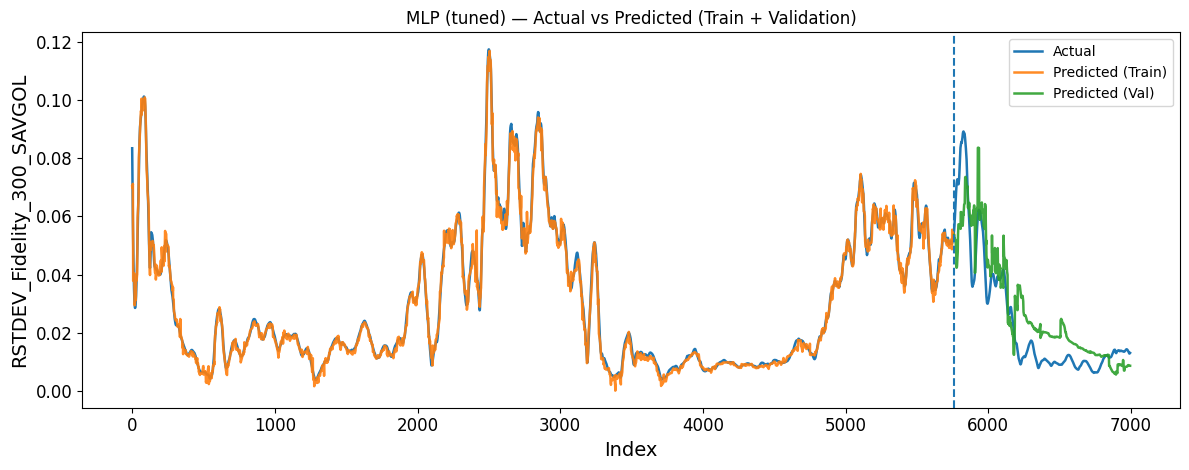

In [ ]:
model_str = "Multilayer Perceptron"

model_name = "mlp_baseline"
tuned_ver = False

reset_tf_state()

np.random.seed(42)
tf.random.set_seed(42)


def build_mlp(n_features, num_layers=2, units=64, activation="relu", learning_rate=1e-3):
    keras.backend.clear_session()
    model = keras.Sequential(name="mlp_regressor")
    model.add(keras.layers.Input(shape=(n_features,)))
    for _ in range(num_layers):
        model.add(keras.layers.Dense(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )
    return model

EPOCHS = 200
# set to 1000 per Dr. W's suggestion
BATCH  = 500

baseline = build_mlp(
    n_features=X_tr_sc.shape[1],
    num_layers=2, units=64, activation="relu", learning_rate=1e-3
)
baseline.fit(X_tr_sc, y_tr_sc, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_sc, y_va_sc))

save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", baseline, nn=True)

yhat_tr_b = baseline.predict(X_tr_sc, verbose=0).ravel() * y_std + y_mean
yhat_va_b = baseline.predict(X_va_sc, verbose=0).ravel() * y_std + y_mean


print("\n=== MLP Baseline ===")

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

In [ ]:
model_name = "mpl_tuned"
tuned_ver = True

rng = np.random.default_rng(42)

layers_choices = [1, 2, 3]
units_choices  = [16, 32, 64, 128, 256]
acts_choices   = ["relu", "tanh", "elu"]
lr_choices     = [1e-4, 3e-4, 1e-3, 3e-3]
N_TRIALS = 20 # make bigger if i want to do a broader search at a later time

best = {"r2": -np.inf, "rmse": np.inf, "params": None, "model": None}

for _ in range(N_TRIALS):
    num_layers = int(rng.choice(layers_choices))
    units      = int(rng.choice(units_choices))
    act        = str(rng.choice(acts_choices))
    lr         = float(rng.choice(lr_choices))

    model = build_mlp(X_tr_sc.shape[1], num_layers=num_layers, units=units,
                      activation=act, learning_rate=lr)

    model.fit(X_tr_sc, y_tr_sc, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_sc, y_va_sc))

    yhat_va = model.predict(X_va_sc, verbose=0).ravel() * y_std + y_mean
    r2_va   = r2_score(y_va, yhat_va)

    if r2_va > best["r2"]:
        best["r2"] = r2_va
        best["rmse"] = float(mean_squared_error(y_va, yhat_va) ** 0.5)
        best["params"] = {"num_layers": num_layers, "units": units, "activation": act, "learning_rate": lr}
        best["model"] = model

print("\n=== Tuned MLP (selected by Val R^2) ===")
print("Best params ->", best["params"])
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

mlp_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", mlp_best, nn=True)

yhat_tr = mlp_best.predict(X_tr_sc, verbose=0).ravel() * y_std + y_mean
yhat_va = mlp_best.predict(X_va_sc, verbose=0).ravel() * y_std + y_mean


print("\n=== Tuned MLP — Full report ===")

print_metrics(model_name, TARGET, Y_tr, Y_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best["params"]
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, Y_tr, Y_va, yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:
try:
    mlp_cfg = best["params"]
    NUM_LAYERS = int(mlp_cfg["num_layers"])
    UNITS      = int(mlp_cfg["units"])
    ACT        = str(mlp_cfg["activation"])
    LR         = float(mlp_cfg["learning_rate"])
except Exception:
    NUM_LAYERS, UNITS, ACT, LR = 2, 64, "relu", 1e-3

GAP  = 0
H    = 1

EPOCHS = 200
BATCH  = 500

np.random.seed(42)
tf.random.set_seed(42)

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    tr_idx = np.arange(0, train_end)
    va_idx = np.arange(val_start, val_end)

    x_scaler = StandardScaler().fit(X_all.iloc[tr_idx])
    X_tr_sc = x_scaler.transform(X_all.iloc[tr_idx])
    X_va_sc = x_scaler.transform(X_all.iloc[va_idx])

    y_tr_slice = Y.iloc[tr_idx]
    y_va_slice = Y.iloc[va_idx]
    y_mean = float(y_tr_slice.mean())
    y_std  = float(y_tr_slice.std(ddof=0)) if float(y_tr_slice.std(ddof=0)) > 0 else 1.0
    y_tr_sc = ((y_tr_slice - y_mean) / y_std).to_numpy()
    y_va_sc = ((y_va_slice - y_mean) / y_std).to_numpy()

    keras.backend.clear_session()
    tf.random.set_seed(42 + fold)

    model = keras.Sequential(name=f"mlp_fold_{fold}")
    model.add(keras.layers.Input(shape=(X_tr_sc.shape[1],)))
    for _ in range(NUM_LAYERS):
        model.add(keras.layers.Dense(UNITS, activation=ACT))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss="mse",
        metrics=["mae"]
    )

    model.fit(
        X_tr_sc, y_tr_sc,
        validation_data=(X_va_sc, y_va_sc),
        epochs=EPOCHS, batch_size=BATCH, verbose=0
    )

    y_pred_sc = model.predict(X_va_sc, verbose=0).ravel()
    y_pred = y_pred_sc * y_std + y_mean

    rmse  = mean_squared_error(y_va_slice, y_pred) ** 0.5
    r2    = r2_score(y_va_slice, y_pred)
    if r2 < 0:
        r2 = 0.0


    # TODO: remove this later? I dont think i need this anymore since I'm not evaluating model skill
    y_prev = Y.shift(H).iloc[va_idx].copy()
    if (va_idx[0] - H) < 0:
        y_prev.iloc[:H] = Y.iloc[train_end - 1]

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.02890
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.0000 | RMSE: 0.03432
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.0000 | RMSE: 0.02173
Val index: (7200 : 8640)

=== Forward-chaining summary (MLP) ===
Mean R^2:       0.0000
Mean RMSE:      0.02832


### Radial Basis Function NN

##### Custom class/function definition:

In [ ]:
X_tr_np = X_tr.to_numpy().astype(np.float32)
X_va_np = X_va.to_numpy().astype(np.float32)

mu_X = X_tr_np.mean(axis=0, keepdims=True)
sd_X = X_tr_np.std(axis=0, ddof=0, keepdims=True)
sd_X[sd_X == 0.0] = 1.0

X_tr_sc = (X_tr_np - mu_X) / sd_X
X_va_sc = (X_va_np - mu_X) / sd_X

y_tr_np = y_tr.to_numpy().astype(np.float32)
y_va_np = y_va.to_numpy().astype(np.float32)

mu_y = float(y_tr_np.mean())
sd_y = float(y_tr_np.std(ddof=0))
if sd_y == 0.0:
    sd_y = 1.0

y_tr_sc = ((y_tr_np - mu_y) / sd_y).astype(np.float32)
y_va_sc = ((y_va_np - mu_y) / sd_y).astype(np.float32)


def build_rbf_model(centers, betas, l2=1e-4, lr=1e-3,
                    trainable_centers=False, trainable_betas=False):
    keras.backend.clear_session()
    inp = keras.Input(shape=(X_tr_sc.shape[1],))
    rbf = RBFLayer(centers, betas,
                   trainable_centers=trainable_centers,
                   trainable_betas=trainable_betas)(inp)
    out = keras.layers.Dense(1, activation="linear",
                             kernel_regularizer=keras.regularizers.l2(l2))(rbf)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])
    return model


def kmeans_np(X, K, max_iter=50, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X_all), size=K, replace=False)
    centers = X_all[idx].copy()

    for _ in range(max_iter):
        d2 = ((X_all[:, None, :] - centers[None, :, :])**2).sum(axis=2)
        labels = d2.argmin(axis=1)
        new_centers = np.zeros_like(centers)
        counts = np.bincount(labels, minlength=K).astype(np.int64)
        for k in range(K):
            if counts[k] > 0:
                new_centers[k] = X_all[labels == k].mean(axis=0)
            else:
                new_centers[k] = X_all[rng.integers(0, len(X))]
        if np.allclose(new_centers, centers):
            break
        centers = new_centers
    return centers


def median_center_distance(centers):
    if centers.shape[0] < 2:
        return 1.0
    diffs = centers[:, None, :] - centers[None, :, :]
    d = np.sqrt(np.maximum((diffs**2).sum(axis=2), 0.0))
    iu = np.triu_indices(len(centers), k=1)
    vals = d[iu]
    return float(np.median(vals)) if vals.size else 1.0


class RBFLayer(keras.layers.Layer):
    """
    found from a model I made for Dr. B's class:
    phi_j(x) = exp(-beta_j * ||x - c_j||^2), j=1..K
    centers: (K, D) initial centers
    betas: (K,) initial beta values  (beta = 1 / (2*sigma^2))
    trainable_* flags control whether centers/betas are learned by gradient descent
    """
    def __init__(self, centers, betas, trainable_centers=False, trainable_betas=False, **kwargs):
        super().__init__(**kwargs)
        self.K = centers.shape[0]
        self.D = centers.shape[1]
        self._init_centers = centers.astype(np.float32)
        self._init_betas = betas.astype(np.float32)
        self.trainable_centers = trainable_centers
        self.trainable_betas = trainable_betas

    def build(self, input_shape):
        self.centers = self.add_weight(
            name="centers",
            shape=(self.K, self.D),
            initializer=keras.initializers.Constant(self._init_centers),
            trainable=self.trainable_centers,
        )
        self.betas = self.add_weight(
            name="betas",
            shape=(self.K,),
            initializer=keras.initializers.Constant(self._init_betas),
            trainable=self.trainable_betas,
            constraint=keras.constraints.NonNeg()
        )

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        c = tf.expand_dims(self.centers, axis=0)
        d2 = tf.reduce_sum(tf.square(x - c), axis=-1)
        return tf.exp(-self.betas * d2)

##### Baseline

In [ ]:
model_str = "Radial Basis Function NN"

model_name = "rbfnn_baseline"
tuned_ver = False

reset_tf_state()


EPOCHS = 200
BATCH  = 500

K_base          = 64
center_method   = "kmeans"
width_scale     = 1.0
l2_base         = 1e-4
lr_base         = 1e-3

if center_method == "kmeans":
    C_base = kmeans_np(X_tr_sc, K_base, max_iter=50, seed=42)
else:
    rng = np.random.default_rng(42)
    idx = rng.choice(len(X_tr_sc), size=K_base, replace=False)
    C_base = X_tr_sc[idx]

sigma_base = width_scale * median_center_distance(C_base)
beta_base  = 1.0 / (2.0 * (sigma_base ** 2))
betas_base = np.full((K_base,), beta_base, dtype=np.float32)

rbf_base = build_rbf_model(C_base, betas_base, l2=l2_base, lr=lr_base,
                           trainable_centers=False, trainable_betas=False)

rbf_base.fit(X_tr_sc, y_tr_sc, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_sc, y_va_sc))

save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", rbf_base, nn=True)

yhat_tr_b = rbf_base.predict(X_tr_sc, verbose=0).ravel() * sd_y + mu_y
yhat_va_b = rbf_base.predict(X_va_sc, verbose=0).ravel() * sd_y + mu_y

print("\n=== RBFN Baseline (TensorFlow) ===")

print_metrics(model_name, TARGET, y_tr_np, y_va_np, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr_np, X_va_np, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr_np, X_va_np, y_tr_np, y_va_np, yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

In [ ]:

model_name = "rbfnn_tuned"
tuned_ver = True

reset_tf_state()


rng = np.random.default_rng(42)
K_choices = [32, 64, 128, 256]
method_choices = ["kmeans", "random"]
N_TRIALS = 20

best = {"r2": -np.inf, "rmse": np.inf, "params": None, "model": None, "centers": None, "betas": None}

for _ in range(N_TRIALS):
    K_t   = int(rng.choice(K_choices))
    m_t   = str(rng.choice(method_choices))
    ws_t  = float(10 ** rng.uniform(np.log10(0.3), np.log10(3.0)))

    if m_t == "kmeans":
        C_t = kmeans_np(X_tr_sc, K_t, max_iter=40, seed=int(rng.integers(1, 1_000_000)))
    else:
        idx = rng.choice(len(X_tr_sc), size=K_t, replace=False)
        C_t = X_tr_sc[idx]

    sigma_t = ws_t * median_center_distance(C_t)
    beta_t  = 1.0 / (2.0 * (sigma_t ** 2))
    betas_t = np.full((K_t,), beta_t, dtype=np.float32)

    model_t = build_rbf_model(C_t, betas_t, l2=1e-4, lr=1e-3,
                              trainable_centers=False, trainable_betas=False)
    model_t.fit(X_tr_sc, y_tr_sc, epochs=EPOCHS, batch_size=BATCH, verbose=0,
                validation_data=(X_va_sc, y_va_sc))

    yhat_va_t = model_t.predict(X_va_sc, verbose=0).ravel() * sd_y + mu_y
    r2_va_t   = r2_score(y_va_np, yhat_va_t)

    if r2_va_t > best["r2"]:
        best["r2"] = r2_va_t
        best["rmse"] = float(mean_squared_error(y_va_np, yhat_va_t) ** 0.5)
        best["params"] = {"K": K_t, "center_method": m_t, "width_scale": ws_t}
        best["model"] = model_t
        best["centers"] = C_t
        best["betas"] = betas_t

print("\n=== Tuned RBFN (selected by Val R^2) ===")
print("Best params ->", best["params"])
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

rbf_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", rbf_best, nn=True)

yhat_tr = rbf_best.predict(X_tr_sc, verbose=0).ravel() * sd_y + mu_y
yhat_va = rbf_best.predict(X_va_sc, verbose=0).ravel() * sd_y + mu_y


print("\n=== Tuned RBFN — Full report ===")

print_metrics(model_name, TARGET, Y_tr_np, Y_va_np, yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best["params"]
)
save_preds(model_name, TARGET, X_tr_np, X_va_np, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr_np, X_va_np, Y_tr_np, Y_va_np, yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

Shapes -> X_tr:(5761, 26), X_va:(1234, 26)

=== RBFN Baseline (TensorFlow) ===
K=64, centers=kmeans, width_scale=1.0, l2=0.0001, lr=0.001
Train | RMSE: 0.01216 | R^2: 0.7262
Val   | RMSE: 0.01095 | R^2: 0.7341

=== Tuned RBFN (selected by Val R^2) ===
Best params -> {'K': 64, 'center_method': 'kmeans', 'width_scale': 0.8970696856037044}
Val metrics  -> R^2: 0.7411 | RMSE: 0.01081

=== Tuned RBFN — Full report ===
Train | RMSE: 0.01218 | R^2: 0.7254
Val   | RMSE: 0.01081 | R^2: 0.7411


##### TSCV

In [ ]:
try:
    rbfn_cfg = best["params"]
    K_best   = int(rbfn_cfg["K"])
    METHOD   = str(rbfn_cfg["center_method"])
    W_SCALE  = float(rbfn_cfg["width_scale"])
except Exception:
    K_best, METHOD, W_SCALE = 64, "kmeans", 1.0



X_np = X_all.to_numpy().astype(np.float32)
y_np = Y.to_numpy().astype(np.float32)
n = len(X_np)

GAP  = 0
H    = 1
EPOCHS = 200
BATCH  = 500

reset_tf_state()

np.random.seed(42)
tf.random.set_seed(42)

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    tr_idx = np.arange(0, train_end)
    va_idx = np.arange(val_start, val_end)

    X_tr_slice = X_np[tr_idx]
    X_va_slice = X_np[va_idx]
    y_tr_slice = y_np[tr_idx]
    y_va_slice = y_np[va_idx]

    mu_X = X_tr_slice.mean(axis=0, keepdims=True)
    sd_X = X_tr_slice.std(axis=0, ddof=0, keepdims=True); sd_X[sd_X == 0.0] = 1.0
    X_tr_sc = (X_tr_slice - mu_X) / sd_X
    X_va_sc = (X_va_slice - mu_X) / sd_X

    mu_y = float(y_tr_slice.mean())
    sd_y = float(y_tr_slice.std(ddof=0)); sd_y = sd_y if sd_y > 0 else 1.0
    y_tr_sc = ((y_tr_slice - mu_y) / sd_y).astype(np.float32)
    y_va_sc = ((y_va_slice - mu_y) / sd_y).astype(np.float32)

    if METHOD == "kmeans":
        C = kmeans_np(X_tr_sc, K_best, max_iter=50, seed=42 + fold)
    else:
        rng = np.random.default_rng(42 + fold)
        idx = rng.choice(len(X_tr_sc), size=K_best, replace=False)
        C = X_tr_sc[idx]

    sigma = W_SCALE * median_center_distance(C)
    beta  = 1.0 / (2.0 * (sigma ** 2))
    betas = np.full((K_best,), beta, dtype=np.float32)

    keras.backend.clear_session()
    tf.random.set_seed(123 + fold)
    model = build_rbf_model(C, betas, l2=1e-4, lr=1e-3,
                            trainable_centers=False, trainable_betas=False)

    model.fit(X_tr_sc, y_tr_sc, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_sc, y_va_sc))

    y_pred_sc = model.predict(X_va_sc, verbose=0).ravel()
    y_pred = y_pred_sc * sd_y + mu_y

    rmse  = mean_squared_error(y_va_slice, y_pred) ** 0.5
    r2    = r2_score(y_va_slice, y_pred)
    if r2 < 0:
        r2 = 0.0


    # persistence baseline ( can probably remove later)
    y_prev = pd.Series(Y).shift(H).iloc[va_idx].to_numpy()
    if (va_idx[0] - H) < 0:
        y_prev[:H] = y_np[train_end - 1]

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.02521
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.7625 | RMSE: 0.01000
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.7176 | RMSE: 0.01062
Val index: (7200 : 8640)

=== Forward-chaining summary (TensorFlow RBFN) ===
Mean R^2:       0.4933
Mean RMSE:      0.01527


# RNNS

In [ ]:
# For RNNS
def make_sequences(X_sc, y_sc, lookback=LOOKBACK, horizon=HORIZON):
    X_seq, y_seq = [], []
    for t in range(lookback, len(X_sc) - horizon + 1):
        X_seq.append(X_sc[t - lookback: t])
        y_seq.append(y_sc[t + horizon - 1])
    X_seq = np.asarray(X_seq, dtype=np.float32)
    y_seq = np.asarray(y_seq, dtype=np.float32)
    return X_seq, y_seq


n = len(df)

X_tr = X_tr_df.to_numpy().astype(np.float32)
X_va = X_va_df.to_numpy().astype(np.float32)

mu_X = X_tr.mean(axis=0, keepdims=True)
sd_X = X_tr.std(axis=0, ddof=0, keepdims=True)
sd_X[sd_X == 0.0] = 1.0

X_tr_sc = (X_tr - mu_X) / sd_X
X_va_sc = (X_va - mu_X) / sd_X

y_tr = y_tr_df.to_numpy().astype(np.float32)
y_va = y_va_df.to_numpy().astype(np.float32)

mu_y = float(y_tr.mean())
sd_y = float(y_tr.std(ddof=0))
sd_y = sd_y if sd_y > 0 else 1.0

y_tr_sc = ((y_tr - mu_y) / sd_y).astype(np.float32)
y_va_sc = ((y_va - mu_y) / sd_y).astype(np.float32)

LOOKBACK = 120
LOOKBACK = 240
HORIZON  = 1

X_tr_seq, y_tr_seq = make_sequences(X_tr_sc, y_tr_sc)
X_va_seq, y_va_seq = make_sequences(X_va_sc, y_va_sc)

print(f"Seq shapes -> X_tr_seq:{X_tr_seq.shape}, X_va_seq:{X_va_seq.shape}")

train_pred_index = X_tr_df.index[LOOKBACK : LOOKBACK + len(y_tr_seq)]
val_pred_index   = X_va_df.index[LOOKBACK : LOOKBACK + len(y_va_seq)]

### Vanilla RNN

##### Baseline

In [ ]:
model_str = "Recurrent Neural Network"

model_name = "rnn_baseline"
tuned_ver = False

reset_tf_state()

def build_rnn(n_features, lookback=LOOKBACK, num_layers=1, units=64, activation="tanh", learning_rate=1e-3):
    keras.backend.clear_session()
    model = keras.Sequential(name="vanilla_rnn")
    model.add(keras.layers.Input(shape=(lookback, n_features)))
    for _ in range(max(0, num_layers - 1)):
        model.add(keras.layers.SimpleRNN(units, activation=activation, return_sequences=True))
    model.add(keras.layers.SimpleRNN(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )
    return model

EPOCHS = 200
BATCH  = 500

baseline = build_rnn(n_features=X_tr_seq.shape[2],
                     num_layers=1, units=64, activation="tanh", learning_rate=1e-3)

baseline.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_seq, y_va_seq))

save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", baseline, nn=True)

yhat_tr_b_sc = baseline.predict(X_tr_seq, verbose=0).ravel()
yhat_va_b_sc = baseline.predict(X_va_seq, verbose=0).ravel()
yhat_tr_b = yhat_tr_b_sc * sd_y + mu_y
yhat_va_b = yhat_va_b_sc * sd_y + mu_y

print("\n=== Vanilla RNN Baseline ===")

print_metrics(model_name, TARGET, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

Seq shapes -> X_tr_seq:(5521, 240, 26), X_va_seq:(994, 240, 26)

=== Vanilla RNN Baseline ===
Train | RMSE: 0.00088 | R^2: 0.9985
Val   | RMSE: 0.01594 | R^2: -1.6658

=== Tuned Vanilla RNN (selected by Val R^2) ===
Best params -> {'num_layers': 3, 'units': 256, 'activation': 'relu', 'learning_rate': 0.003}
Val metrics  -> R^2: 0.8152 | RMSE: 0.00420

=== Tuned Vanilla RNN — Full report ===
Train | RMSE: 0.00243 | R^2: 0.9884
Val   | RMSE: 0.00420 | R^2: 0.8152


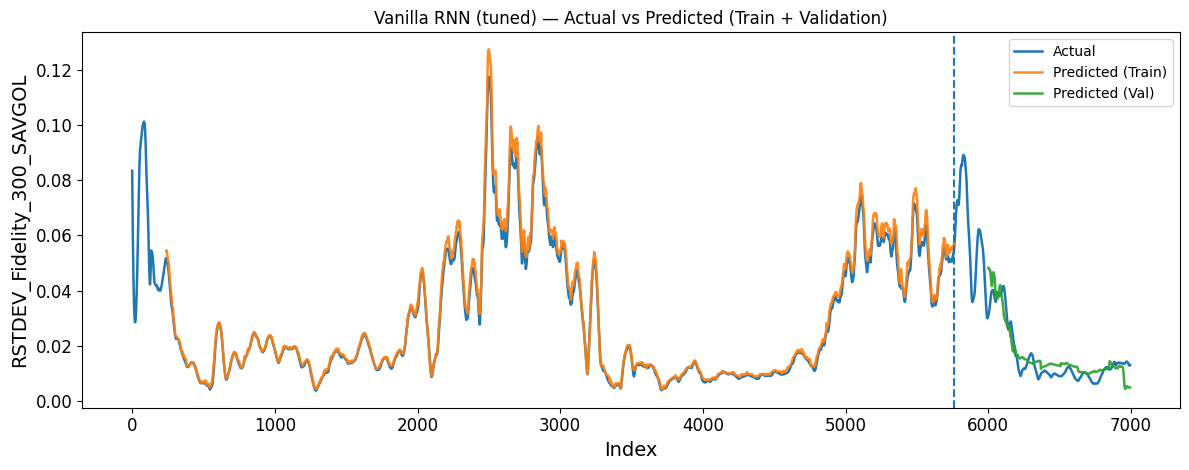

In [ ]:
model_name = "rnn_tuned"
tuned_ver = True

reset_tf_state()

def build_rnn(n_features, lookback=LOOKBACK, num_layers=1, units=64, activation="tanh", learning_rate=1e-3):
    keras.backend.clear_session()
    model = keras.Sequential(name="vanilla_rnn")
    model.add(keras.layers.Input(shape=(lookback, n_features)))
    for _ in range(max(0, num_layers - 1)):
        model.add(keras.layers.SimpleRNN(units, activation=activation, return_sequences=True))
    model.add(keras.layers.SimpleRNN(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"]
    )
    return model

EPOCHS = 200
BATCH  = 500

baseline = build_rnn(n_features=X_tr_seq.shape[2],
                     num_layers=1, units=64, activation="tanh", learning_rate=1e-3)

baseline.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_seq, y_va_seq))

yhat_tr_b_sc = baseline.predict(X_tr_seq, verbose=0).ravel()
yhat_va_b_sc = baseline.predict(X_va_seq, verbose=0).ravel()
yhat_tr_b = yhat_tr_b_sc * sd_y + mu_y
yhat_va_b = yhat_va_b_sc * sd_y + mu_y

rmse_tr_b = mean_squared_error(y_tr[LOOKBACK:], yhat_tr_b) ** 0.5
rmse_va_b = mean_squared_error(y_va[LOOKBACK:], yhat_va_b) ** 0.5
r2_tr_b   = r2_score(y_tr[LOOKBACK:], yhat_tr_b)
r2_va_b   = r2_score(y_va[LOOKBACK:], yhat_va_b)

print("\n=== Vanilla RNN Baseline ===")
print(f"Train | RMSE: {rmse_tr_b:.5f} | R^2: {r2_tr_b:.4f}")
print(f"Val   | RMSE: {rmse_va_b:.5f} | R^2: {r2_va_b:.4f}")

rng = np.random.default_rng(123)
layers_choices = [1, 2, 3]
units_choices  = [16, 32, 64, 128, 256]
acts_choices   = ["tanh", "relu"]
lr_choices     = [1e-4, 3e-4, 1e-3, 3e-3]
N_TRIALS = 20

best = {"r2": -np.inf, "rmse": np.inf, "params": None, "model": None}

for trial in range(N_TRIALS):
    num_layers = int(rng.choice(layers_choices))
    units      = int(rng.choice(units_choices))
    act        = str(rng.choice(acts_choices))
    lr         = float(rng.choice(lr_choices))

    model = build_rnn(X_tr_seq.shape[2], num_layers=num_layers, units=units,
                      activation=act, learning_rate=lr)

    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    yhat_va_sc = model.predict(X_va_seq, verbose=0).ravel()
    yhat_va = yhat_va_sc * sd_y + mu_y
    r2_va   = r2_score(y_va[LOOKBACK:], yhat_va)

    if r2_va > best["r2"]:
        best["r2"] = r2_va
        best["rmse"] = float(mean_squared_error(y_va[LOOKBACK:], yhat_va) ** 0.5)
        best["params"] = {"num_layers": num_layers, "units": units, "activation": act, "learning_rate": lr}
        best["model"] = model

print("\n=== Tuned Vanilla RNN (selected by Val R^2) ===")
print("Best params ->", best["params"])
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

rnn_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", rnn_best, nn=True)

yhat_tr_sc = rnn_best.predict(X_tr_seq, verbose=0).ravel()
yhat_va_sc = rnn_best.predict(X_va_seq, verbose=0).ravel()
yhat_tr = yhat_tr_sc * sd_y + mu_y
yhat_va = yhat_va_sc * sd_y + mu_y

rmse_tr = mean_squared_error(y_tr[LOOKBACK:], yhat_tr) ** 0.5
rmse_va = mean_squared_error(y_va[LOOKBACK:], yhat_va) ** 0.5
r2_tr   = r2_score(y_tr[LOOKBACK:], yhat_tr)
r2_va   = r2_score(y_va[LOOKBACK:], yhat_va)


print("\n=== Tuned Vanilla RNN — Full report ===")

print_metrics(model_name, TARGET, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr, yhat_va, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best["params"]
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr, yhat_va, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr, yhat_va, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:
try:
    rnn_cfg = best["params"]
    assert all(k in rnn_cfg for k in ["num_layers","units","activation","learning_rate"])
    NUM_LAYERS = int(rnn_cfg["num_layers"])
    UNITS      = int(rnn_cfg["units"])
    ACT        = str(rnn_cfg["activation"])
    LR         = float(rnn_cfg["learning_rate"])
except Exception:
    NUM_LAYERS, UNITS, ACT, LR = 1, 64, "tanh", 1e-3


X_np = X_all.to_numpy().astype(np.float32)
y_np = Y.to_numpy().astype(np.float32)
n = len(X_np)

GAP   = 0
LOOKBACK = 120
HORIZON  = 1
EPOCHS = 200
BATCH  = 500

reset_tf_state()

np.random.seed(42)
tf.random.set_seed(42)

def build_rnn(n_features, num_layers=NUM_LAYERS, units=UNITS, activation=ACT, learning_rate=LR):
    keras.backend.clear_session()
    model = keras.Sequential(name="vanilla_rnn_cv")
    model.add(keras.layers.Input(shape=(LOOKBACK, n_features)))
    for _ in range(max(0, num_layers - 1)):
        model.add(keras.layers.SimpleRNN(units, activation=activation, return_sequences=True))
    model.add(keras.layers.SimpleRNN(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse", metrics=["mae"])
    return model

fold = 1
train_end = DAY

fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    X_tr_slice = X_np[:train_end]
    mu_X = X_tr_slice.mean(axis=0, keepdims=True)
    sd_X = X_tr_slice.std(axis=0, ddof=0, keepdims=True); sd_X[sd_X == 0.0] = 1.0

    X_sc_all = (X_np - mu_X) / sd_X
    y_tr_slice = y_np[:train_end]
    mu_y = float(y_tr_slice.mean())
    sd_y = float(y_tr_slice.std(ddof=0)); sd_y = sd_y if sd_y > 0 else 1.0

    tr_t0 = LOOKBACK
    tr_t1 = train_end - HORIZON + 1
    X_tr_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(tr_t0, tr_t1)], axis=0)
    y_tr_seq = np.stack([((y_np[t+HORIZON-1] - mu_y) / sd_y) for t in range(tr_t0, tr_t1)], axis=0).astype(np.float32)

    va_t0 = val_start
    va_t1 = val_end - HORIZON + 1
    X_va_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(va_t0, va_t1)], axis=0)
    val_target_idx = np.arange(val_start + HORIZON - 1, val_end)
    y_va_true = y_np[val_target_idx]
    y_va_seq  = ((y_va_true - mu_y) / sd_y).astype(np.float32)

    tf.random.set_seed(123 + fold)
    model = build_rnn(n_features=X_tr_seq.shape[2])
    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    y_pred_sc = model.predict(X_va_seq, verbose=0).ravel()
    y_pred = y_pred_sc * sd_y + mu_y

    rmse  = mean_squared_error(y_va_true, y_pred) ** 0.5
    r2    = r2_score(y_va_true, y_pred)
    if r2 < 0:
        r2 = 0.0


    # TODO: remove later
    y_prev = y_np[val_target_idx - HORIZON]
    rmse_persist = mean_squared_error(y_va_true, y_prev) ** 0.5

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.02968
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.4061 | RMSE: 0.01581
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.6017 | RMSE: 0.01261
Val index: (7200 : 8640)

=== Forward-chaining summary (Vanilla RNN) ===
Mean R^2:       0.3359
Mean RMSE:      0.01937


### LSTM RNN

##### Baseline

Seq shapes -> X_tr_seq:(5521, 240, 26), X_va_seq:(994, 240, 26)

=== LSTM Baseline ===
Train | RMSE: 0.00041 | R^2: 0.9997
Val   | RMSE: 0.00898 | R^2: 0.1543

=== Tuned LSTM (selected by Val R^2) ===
Best params -> {'num_layers': 2, 'units': 32, 'activation': 'tanh', 'learning_rate': 0.003}
Val metrics  -> R^2: 0.8878 | RMSE: 0.00327

=== Tuned LSTM — Full report ===
Train | RMSE: 0.00060 | R^2: 0.9993
Val   | RMSE: 0.00327 | R^2: 0.8878


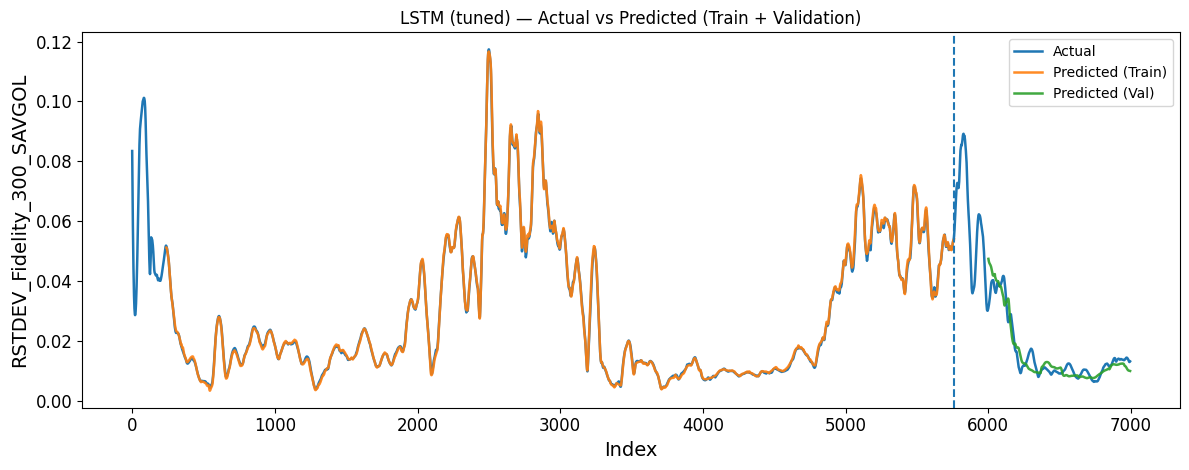

In [ ]:
model_str = "Long Short Term Memory RNN"

model_name = "lstm_baseline"
tuned_ver = False

tf.keras.backend.clear_session()
gc.collect()


X_tr = X_tr_df.to_numpy().astype(np.float32)
X_va = X_va_df.to_numpy().astype(np.float32)

mu_X = X_tr.mean(axis=0, keepdims=True)
sd_X = X_tr.std(axis=0, ddof=0, keepdims=True)
sd_X[sd_X == 0.0] = 1.0

X_tr_sc = (X_tr - mu_X) / sd_X
X_va_sc = (X_va - mu_X) / sd_X

y_tr = y_tr_df.to_numpy().astype(np.float32)
y_va = y_va_df.to_numpy().astype(np.float32)

mu_y = float(y_tr.mean())
sd_y = float(y_tr.std(ddof=0));  sd_y = sd_y if sd_y > 0 else 1.0

y_tr_sc = ((y_tr - mu_y) / sd_y).astype(np.float32)
y_va_sc = ((y_va - mu_y) / sd_y).astype(np.float32)

LOOKBACK = 120
LOOKBACK = 240
HORIZON  = 1

def make_sequences(X_sc, y_sc, lookback=LOOKBACK, horizon=HORIZON):
    X_seq, y_seq = [], []
    for t in range(lookback, len(X_sc) - horizon + 1):
        X_seq.append(X_sc[t - lookback: t])
        y_seq.append(y_sc[t + horizon - 1])
    return np.asarray(X_seq, np.float32), np.asarray(y_seq, np.float32)

X_tr_seq, y_tr_seq = make_sequences(X_tr_sc, y_tr_sc)
X_va_seq, y_va_seq = make_sequences(X_va_sc, y_va_sc)

print(f"Seq shapes -> X_tr_seq:{X_tr_seq.shape}, X_va_seq:{X_va_seq.shape}")

train_pred_index = X_tr_df.index[LOOKBACK : LOOKBACK + len(y_tr_seq)]
val_pred_index   = X_va_df.index[LOOKBACK : LOOKBACK + len(y_va_seq)]

def build_lstm(n_features, num_layers=1, units=64, activation="tanh", learning_rate=1e-3):
    keras.backend.clear_session()
    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model = keras.Sequential(name="lstm_regressor")
    model.add(keras.layers.Input(shape=(LOOKBACK, n_features)))
    for _ in range(max(0, num_layers - 1)):
        model.add(keras.layers.LSTM(units, activation=activation, return_sequences=True))
    model.add(keras.layers.LSTM(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

EPOCHS = 200
BATCH  = 500

baseline = build_lstm(
    n_features=X_tr_seq.shape[2],
    num_layers=1, units=64, activation="tanh", learning_rate=1e-3
)
baseline.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_seq, y_va_seq))
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", baseline, nn=True)

yhat_tr_b = baseline.predict(X_tr_seq, verbose=0).ravel() * sd_y + mu_y
yhat_va_b = baseline.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y


print("\n=== LSTM Baseline ===")


print_metrics(model_name, TARGET, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

In [ ]:

model_name = "lstm_tuned"
tuned_ver = True

rng = np.random.default_rng(123)
layers_choices = [1, 2, 3]
units_choices  = [16, 32, 64, 128, 256]
acts_choices   = ["tanh", "relu"]
lr_choices     = [1e-4, 3e-4, 1e-3, 3e-3]
N_TRIALS = 20

best = {"r2": -np.inf, "rmse": np.inf, "params": None, "model": None}

for _ in range(N_TRIALS):
    num_layers = int(rng.choice(layers_choices))
    units      = int(rng.choice(units_choices))
    act        = str(rng.choice(acts_choices))
    lr         = float(rng.choice(lr_choices))

    model = build_lstm(X_tr_seq.shape[2], num_layers=num_layers, units=units,
                       activation=act, learning_rate=lr)

    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    yhat_va = model.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y
    #r2_va   = r2_score(y_va[LOOKBACK:], yhat_va)



    y_true_va = np.asarray(y_va[LOOKBACK : LOOKBACK + len(yhat_va)], dtype=float)
    y_pred_va = np.asarray(yhat_va, dtype=float)
    
    mask = np.isfinite(y_true_va) & np.isfinite(y_pred_va)
    if mask.sum() < 2:
        r2_va   = np.nan
        rmse_va = np.nan
    else:
        r2_va   = r2_score(y_true_va[mask], y_pred_va[mask])
        rmse_va = mean_squared_error(y_true_va[mask], y_pred_va[mask]) ** 0.5

    

    if r2_va > best["r2"]:
        best["r2"]  = r2_va
        best["rmse"] = float(mean_squared_error(y_va[LOOKBACK:], yhat_va) ** 0.5)
        best["params"] = {"num_layers": num_layers, "units": units, "activation": act, "learning_rate": lr}
        best["model"] = model

print("\n=== Tuned LSTM (selected by Val R^2) ===")
print("Best params ->", best["params"])
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

lstm_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", lstm_best, nn=True)

yhat_tr = lstm_best.predict(X_tr_seq, verbose=0).ravel() * sd_y + mu_y
yhat_va = lstm_best.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y


print("\n=== Tuned LSTM — Full report ===")

print_metrics(model_name, TARGET, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best["params"]
)
save_preds(model_name, TARGET, X_tr, X_va, yhat_tr_b, yhat_va_b, step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_tr[LOOKBACK:], y_va[LOOKBACK:], yhat_tr_b, yhat_va_b, model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

try:
    cfg = best["params"]
    NUM_LAYERS = int(cfg["num_layers"])
    UNITS      = int(cfg["units"])
    ACT        = str(cfg["activation"])
    LR         = float(cfg["learning_rate"])
except Exception:
    NUM_LAYERS, UNITS, ACT, LR = 1, 64, "tanh", 1e-3


X_np = X_all.to_numpy().astype(np.float32)
y_np = Y.to_numpy().astype(np.float32)
n = len(X_np)

GAP   = 0
LOOKBACK = 120
HORIZON  = 1
EPOCHS = 200
BATCH  = 500

def build_lstm(n_features, num_layers=NUM_LAYERS, units=UNITS, activation=ACT, learning_rate=LR):
    keras.backend.clear_session()
    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    m = keras.Sequential(name="lstm_cv")
    m.add(keras.layers.Input(shape=(LOOKBACK, n_features)))
    for _ in range(max(0, num_layers - 1)):
        m.add(keras.layers.LSTM(units, activation=activation, return_sequences=True))
    m.add(keras.layers.LSTM(units, activation=activation))
    m.add(keras.layers.Dense(1, activation="linear"))
    m.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return m

fold = 1
train_end = DAY
fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    X_tr_slice = X_np[:train_end]
    mu_X = X_tr_slice.mean(axis=0, keepdims=True)
    sd_X = X_tr_slice.std(axis=0, ddof=0, keepdims=True); sd_X[sd_X == 0.0] = 1.0
    X_sc_all = (X_np - mu_X) / sd_X

    y_tr_slice = y_np[:train_end]
    mu_y = float(y_tr_slice.mean())
    sd_y = float(y_tr_slice.std(ddof=0));  sd_y = sd_y if sd_y > 0 else 1.0

    tr_t0 = LOOKBACK
    tr_t1 = train_end - HORIZON + 1
    if tr_t1 - tr_t0 < 2:
        print("  [Skip] Not enough train sequences in this fold.")
        train_end += HALF
        fold += 1
        continue
    X_tr_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(tr_t0, tr_t1)], axis=0)
    y_tr_seq = np.stack([((y_np[t+HORIZON-1] - mu_y) / sd_y) for t in range(tr_t0, tr_t1)], axis=0).astype(np.float32)

    va_t0 = val_start
    va_t1 = val_end - HORIZON + 1
    if va_t1 - va_t0 < 2:
        print("  [Skip] Not enough validation sequences in this fold.")
        train_end += HALF
        fold += 1
        continue
    X_va_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(va_t0, va_t1)], axis=0)
    val_target_idx = np.arange(val_start + HORIZON - 1, val_end)
    y_va_true = y_np[val_target_idx]
    y_va_seq  = ((y_va_true - mu_y) / sd_y).astype(np.float32)

    np.random.seed(42 + fold)
    tf.random.set_seed(42 + fold)
    model = build_lstm(n_features=X_tr_seq.shape[2])

    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    y_pred_sc = model.predict(X_va_seq, verbose=0).ravel()
    y_pred = y_pred_sc * sd_y + mu_y

    mlen = min(len(y_pred), len(y_va_true))
    y_pred = y_pred[:mlen].astype(float)
    y_true = y_va_true[:mlen].astype(float)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 2:
        r2 = np.nan
        rmse = np.nan
    else:
        r2   = r2_score(y_true[mask], y_pred[mask])
        if r2 < 0:
            r2 = 0.0
        rmse = mean_squared_error(y_true[mask], y_pred[mask]) ** 0.5

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1



print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.03095
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.4139 | RMSE: 0.01571
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.7462 | RMSE: 0.01006
Val index: (7200 : 8640)

=== Forward-chaining summary (LSTM) ===
Mean R^2:       0.3867
Mean RMSE:      0.01891


### GRU RNN

##### Baseline

Seq shapes -> X_tr_seq:(5521, 240, 26), X_va_seq:(994, 240, 26)

=== GRU Baseline ===
Train | RMSE: 0.00059 | R^2: 0.9993
Val   | RMSE: 0.00907 | R^2: 0.1375

=== Tuned GRU (selected by Val R^2) ===
Best params -> {'num_layers': 2, 'units': 128, 'activation': 'tanh', 'learning_rate': 0.003}
Val metrics  -> R^2: 0.8252 | RMSE: 0.00408

=== Tuned GRU — Full report ===
Train | RMSE: 0.00069 | R^2: 0.9991
Val   | RMSE: 0.00408 | R^2: 0.8252


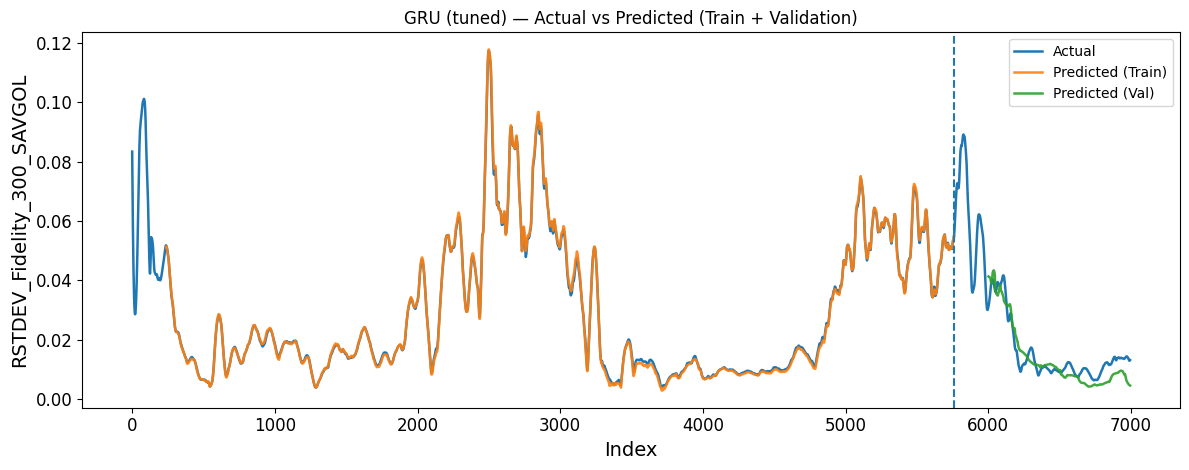

In [ ]:
model_str = "Gated Recurrent Unit RNN"

model_name = "gru_baseline"
tuned_ver = False

tf.keras.backend.clear_session()
gc.collect()

# loaded this notebook from a previous run and think the kernel reset, so setting seed again
np.random.seed(42)
tf.random.set_seed(42)


# TODO: Rename all of these later so they don't conflict with the nonlinear regreaaor sets (rename to something like X_tr_np etc)
X_tr = X_tr_df.to_numpy().astype(np.float32)
X_va = X_va_df.to_numpy().astype(np.float32)

mu_X = X_tr.mean(axis=0, keepdims=True)
sd_X = X_tr.std(axis=0, ddof=0, keepdims=True)
sd_X[sd_X == 0.0] = 1.0

X_tr_sc = (X_tr - mu_X) / sd_X
X_va_sc = (X_va - mu_X) / sd_X

y_tr = y_tr_df.to_numpy().astype(np.float32)
y_va = y_va_df.to_numpy().astype(np.float32)

mu_y = float(y_tr.mean())
sd_y = float(y_tr.std(ddof=0))
sd_y = sd_y if sd_y > 0 else 1.0

y_tr_sc = ((y_tr - mu_y) / sd_y).astype(np.float32)
y_va_sc = ((y_va - mu_y) / sd_y).astype(np.float32)

LOOKBACK = GRU_LOOKBACK

X_tr_seq, y_tr_seq = make_sequences(X_tr_sc, y_tr_sc)
X_va_seq, y_va_seq = make_sequences(X_va_sc, y_va_sc)

print(f"Seq shapes -> X_tr_seq:{X_tr_seq.shape}, X_va_seq:{X_va_seq.shape}")

train_pred_index = X_tr_df.index[LOOKBACK : LOOKBACK + len(y_tr_seq)]
val_pred_index   = X_va_df.index[LOOKBACK : LOOKBACK + len(y_va_seq)]

def build_gru(n_features, num_layers=1, units=64, activation="tanh", learning_rate=1e-3):
    keras.backend.clear_session()
    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model = keras.Sequential(name="gru_regressor")
    model.add(keras.layers.Input(shape=(LOOKBACK, n_features)))
    for _ in range(max(0, num_layers - 1)):
        model.add(keras.layers.GRU(units, activation=activation, return_sequences=True))
    model.add(keras.layers.GRU(units, activation=activation))
    model.add(keras.layers.Dense(1, activation="linear"))
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

EPOCHS = 200
BATCH  = 500

tf.keras.backend.clear_session()
np.random.seed(42); tf.random.set_seed(42)

baseline = build_gru(
    n_features=X_tr_seq.shape[2],
    num_layers=1, units=64, activation="tanh", learning_rate=1e-3
)
baseline.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
             validation_data=(X_va_seq, y_va_seq))
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", baseline, nn=True)

yhat_tr_b = baseline.predict(X_tr_seq, verbose=0).ravel() * sd_y + mu_y
yhat_va_b = baseline.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y

y_true_tr = y_tr[LOOKBACK : LOOKBACK + len(yhat_tr_b)].astype(float)
y_pred_tr = yhat_tr_b.astype(float)
mask_tr = np.isfinite(y_true_tr) & np.isfinite(y_pred_tr)

y_true_va = y_va[LOOKBACK : LOOKBACK + len(yhat_va_b)].astype(float)
y_pred_va = yhat_va_b.astype(float)
mask_va = np.isfinite(y_true_va) & np.isfinite(y_pred_va)


print("\n=== GRU Baseline ===")

print_metrics(model_name, TARGET, y_true_tr[mask_tr], y_true_va[mask_va], y_pred_tr[mask_tr], y_pred_va[mask_va], step_size=SAMPLING.label, save=True)
save_preds(model_name, TARGET, X_tr, X_va, y_pred_tr[mask_tr], y_pred_va[mask_va], step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_true_tr[mask_tr], y_true_va[mask_va], y_pred_tr[mask_tr], y_pred_va[mask_va], model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### Tuned

In [ ]:

model_name = "gru_tuned"
tuned_ver = True

rng = np.random.default_rng(123)
layers_choices = [1, 2, 3]
units_choices  = [16, 32, 64, 128, 256]
acts_choices   = ["tanh", "relu"]
lr_choices     = [1e-4, 3e-4, 1e-3, 3e-3]
N_TRIALS = 20

best = {"r2": -np.inf, "rmse": np.inf, "params": None, "model": None}

for t in range(N_TRIALS):
    num_layers = int(rng.choice(layers_choices))
    units      = int(rng.choice(units_choices))
    act        = str(rng.choice(acts_choices))
    lr         = float(rng.choice(lr_choices))

    np.random.seed(1000 + t); tf.random.set_seed(1000 + t)
    model = build_gru(X_tr_seq.shape[2], num_layers=num_layers, units=units,
                      activation=act, learning_rate=lr)

    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    yhat_va = model.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y

    y_true_va = y_va[LOOKBACK : LOOKBACK + len(yhat_va)].astype(float)
    y_pred_va = yhat_va.astype(float)
    mask = np.isfinite(y_true_va) & np.isfinite(y_pred_va)

    r2_va = r2_score(y_true_va[mask], y_pred_va[mask]) if mask.sum() >= 2 else np.nan
    if np.isnan(r2_va):
        continue

    if r2_va > best["r2"]:
        best["r2"]   = r2_va
        best["rmse"] = float(mean_squared_error(y_true_va[mask], y_pred_va[mask]) ** 0.5)
        best["params"] = {"num_layers": num_layers, "units": units, "activation": act, "learning_rate": lr}
        best["model"]  = model

print("\n=== Tuned GRU (selected by Val R^2) ===")
print("Best params ->", best["params"])
print(f"Val metrics  -> R^2: {best['r2']:.4f} | RMSE: {best['rmse']:.5f}")

gru_best = best["model"]
save_model(f"model_{SAMPLING.label}_{TARGET}_{model_name}", gru_best, nn=True)

yhat_tr = gru_best.predict(X_tr_seq, verbose=0).ravel() * sd_y + mu_y
yhat_va = gru_best.predict(X_va_seq, verbose=0).ravel() * sd_y + mu_y

y_true_tr = y_tr[LOOKBACK : LOOKBACK + len(yhat_tr)].astype(float)
y_pred_tr = yhat_tr.astype(float)
mask_tr = np.isfinite(y_true_tr) & np.isfinite(y_pred_tr)

y_true_va = y_va[LOOKBACK : LOOKBACK + len(yhat_va)].astype(float)
y_pred_va = yhat_va.astype(float)
mask_va = np.isfinite(y_true_va) & np.isfinite(y_pred_va)


print("\n=== Tuned GRU — Full report ===")

print_metrics(model_name, TARGET, y_true_tr[mask_tr], y_true_va[mask_va], y_pred_tr[mask_tr], y_pred_va[mask_va], step_size=SAMPLING.label, save=True)
log_hyperparams(
    SAMPLING.label,
    model_str,
    TARGET,
    best["params"]
)
save_preds(model_name, TARGET, X_tr, X_va, y_pred_tr[mask_tr], y_pred_va[mask_va], step_size=SAMPLING.label, save_dir="data/plotdata")
plot_res_train_val(df, X_tr, X_va, y_true_tr[mask_tr], y_true_va[mask_va], y_pred_tr[mask_tr], y_pred_va[mask_va], model_str, TARGET, tuned=tuned_ver, step_size=SAMPLING.seconds, save=True)

##### TSCV

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

try:
    cfg = best["params"]
    NUM_LAYERS = int(cfg["num_layers"])
    UNITS      = int(cfg["units"])
    ACT        = str(cfg["activation"])
    LR         = float(cfg["learning_rate"])
except Exception:
    NUM_LAYERS, UNITS, ACT, LR = 1, 64, "tanh", 1e-3


X_np = X_all.to_numpy().astype(np.float32)
y_np = Y.to_numpy().astype(np.float32)
n = len(X_np)

GAP    = 0
LOOKBACK = 120
HORIZON  = 1
EPOCHS = 200
BATCH  = 500

def build_gru(n_features, num_layers=NUM_LAYERS, units=UNITS, activation=ACT, learning_rate=LR):
    keras.backend.clear_session()
    opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    m = keras.Sequential(name="gru_cv")
    m.add(keras.layers.Input(shape=(LOOKBACK, n_features)))
    for _ in range(max(0, num_layers - 1)):
        m.add(keras.layers.GRU(units, activation=activation, return_sequences=True))
    m.add(keras.layers.GRU(units, activation=activation))
    m.add(keras.layers.Dense(1, activation="linear"))
    m.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return m

fold = 1
train_end = DAY
fold_r2, fold_rmse = [], []

while True:
    val_start = train_end + GAP
    val_end   = val_start + HALF
    print(f"Val index: ({val_start} : {val_end})")
    if val_end > n:
        break

    X_tr_slice = X_np[:train_end]
    mu_X = X_tr_slice.mean(axis=0, keepdims=True)
    sd_X = X_tr_slice.std(axis=0, ddof=0, keepdims=True); sd_X[sd_X == 0.0] = 1.0
    X_sc_all = (X_np - mu_X) / sd_X

    y_tr_slice = y_np[:train_end]
    mu_y = float(y_tr_slice.mean())
    sd_y = float(y_tr_slice.std(ddof=0)); sd_y = sd_y if sd_y > 0 else 1.0

    tr_t0 = LOOKBACK
    tr_t1 = train_end - HORIZON + 1
    if tr_t1 - tr_t0 < 2:
        print("  [Skip] Not enough train sequences in this fold.")
        train_end += HALF; fold += 1; continue
    X_tr_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(tr_t0, tr_t1)], axis=0)
    y_tr_seq = np.stack([((y_np[t+HORIZON-1] - mu_y) / sd_y) for t in range(tr_t0, tr_t1)], axis=0).astype(np.float32)

    va_t0 = val_start
    va_t1 = val_end - HORIZON + 1
    if va_t1 - va_t0 < 2:
        print("  [Skip] Not enough validation sequences in this fold.")
        train_end += HALF; fold += 1; continue
    X_va_seq = np.stack([X_sc_all[t-LOOKBACK:t] for t in range(va_t0, va_t1)], axis=0)

    val_target_idx = np.arange(val_start + HORIZON - 1, val_end)
    y_va_true = y_np[val_target_idx]
    y_va_seq  = ((y_va_true - mu_y) / sd_y).astype(np.float32)

    np.random.seed(42 + fold); tf.random.set_seed(42 + fold)
    model = build_gru(n_features=X_tr_seq.shape[2])

    model.fit(X_tr_seq, y_tr_seq, epochs=EPOCHS, batch_size=BATCH, verbose=0,
              validation_data=(X_va_seq, y_va_seq))

    y_pred_sc = model.predict(X_va_seq, verbose=0).ravel()
    y_pred = y_pred_sc * sd_y + mu_y

    mlen = min(len(y_pred), len(y_va_true))
    y_pred = y_pred[:mlen].astype(float)
    y_true = y_va_true[:mlen].astype(float)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() < 2:
        r2 = np.nan
        rmse = np.nan
    else:
        r2   = r2_score(y_true[mask], y_pred[mask])
        rmse = mean_squared_error(y_true[mask], y_pred[mask]) ** 0.5


    if r2 < 0:
        r2 = 0.0

    print(f"Fold {fold} | train[0:{train_end}) val[{val_start}:{val_end}) "
          f"| R^2: {r2:.4f} | RMSE: {rmse:.5f}")

    fold_r2.append(r2)
    fold_rmse.append(rmse)

    train_end += HALF
    fold += 1


print_tscv_metrics(model_str, TARGET, fold_r2, fold_rmse, step_size=SAMPLING.label, save=True)

Val index: (2880 : 4320)
Fold 1 | train[0:2880) val[2880:4320) | R^2: 0.0000 | RMSE: 0.03397
Val index: (4320 : 5760)
Fold 2 | train[0:4320) val[4320:5760) | R^2: 0.5863 | RMSE: 0.01320
Val index: (5760 : 7200)
Fold 3 | train[0:5760) val[5760:7200) | R^2: 0.6085 | RMSE: 0.01250
Val index: (7200 : 8640)

=== Forward-chaining summary (GRU) ===
Mean R^2:       0.3983
Mean RMSE:      0.01989
